<a href="https://colab.research.google.com/github/TianyiYe98/DenoisegOCT/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [1]:
import google
import pathlib
import os

google.colab.drive.mount('/content/drive', force_remount=True)
os.chdir('drive/MyDrive/Deep_OCT/DenoiSegOCT') # Use your own path
# If run locally skip this

Mounted at /content/drive


##Requirements

In [2]:
!pip install -e .
!pip install tensorflow==2.8.0
!pip install tensorflow-addons
!pip install validators 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Deep_OCT/DenoiSegOCT
  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: denoiseg
    Found existing installation: denoiseg 0.3.0
    Can't uninstall 'denoiseg'. No files were found to uninstall.
  Running setup.py develop for denoiseg
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires keras<2.9,>=2.8.0rc0, but you have keras 2.3.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile
import cv2
import json
from pathlib import Path
import skimage.segmentation as seg
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,LabelBinarizer
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator


# data load

In [4]:
## one-hot encoding and fill in 

train_images = np.load('data/clean_trainset.npy')
train_noisy_images = np.load('data/noisy_trainset.npy')
train_labels = np.load('data/label_trainset.npy')

validation_images = np.load('data/clean_validset.npy')
validation_noisy_images = np.load('data/noisy_validset.npy')
validation_labels = np.load('data/label_validset.npy')

test_images = np.load('data/clean_testset.npy')
test_noisy_images = np.load('data/noisy_testset.npy')
test_labels = np.load('data/label_testset.npy')

def fill(label):
    filled = np.zeros([label.shape[0],512,512])
    for s in range(label.shape[0]):
        for i in range(10):
            if i == 0:
                top = 0
                for column in range(label.shape[2]):
                    bottom = np.where(label[s,i,:,column]==1)

                    filled[s, top:bottom[0][0],column] = i
            elif i>0:
                for column in range(label.shape[2]):
                    top = np.where(label[s,i-1,:,column]==1)
                    bottom = np.where(label[s,i,:,column]==1)
                    filled[s, top[0][0]:bottom[0][0],column] = i
        
    return filled

def onehot_from_pos(label):
    nlabel = np.zeros([label.shape[0],10,512,512])

    for s in range(label.shape[0]):
        # each surface
        for i in range(label.shape[1]):
            pos = label[s,i,:,:].astype('int16')

            # pos[1] is the y-axis coordinates
            for idx,y in enumerate(pos[1]):
                # nlabel[s,i,y,idx] = 1
                if y>=512:
                    y = 511
                nlabel[s,i,y,idx] = 1

    return nlabel

def onehotdecode(label,bin = 1):
    label1 = np.zeros([label.shape[0],512,512])
    for s in range(label.shape[0]):
        for i in range(label.shape[1]):
            for column in range(label.shape[2]):
                # top = np.where(label[:,column,i-1]==1)
                surface = np.where(label[s,i,:,column]==1)
                if bin == 1:
                    label1[s,surface,column] = 1
                else:
                    label1[s,surface,column] = (i+1)*15
    return label1

    

label_train = train_labels
label_valid = validation_labels
label_test = test_labels
label_train = onehot_from_pos(label_train)
label_valid = onehot_from_pos(label_valid)
label_test = onehot_from_pos(label_test)
# label1 can immediately be used as the delineated surface label 
label1_train = onehotdecode(label_train)
label1_valid = onehotdecode(label_valid)
label1_test = onehotdecode(label_test)

# fill to get pixel-wise label
filled_train = fill(label_train)
filled_valid = fill(label_valid)
filled_test = fill(label_test)

## Display data sample

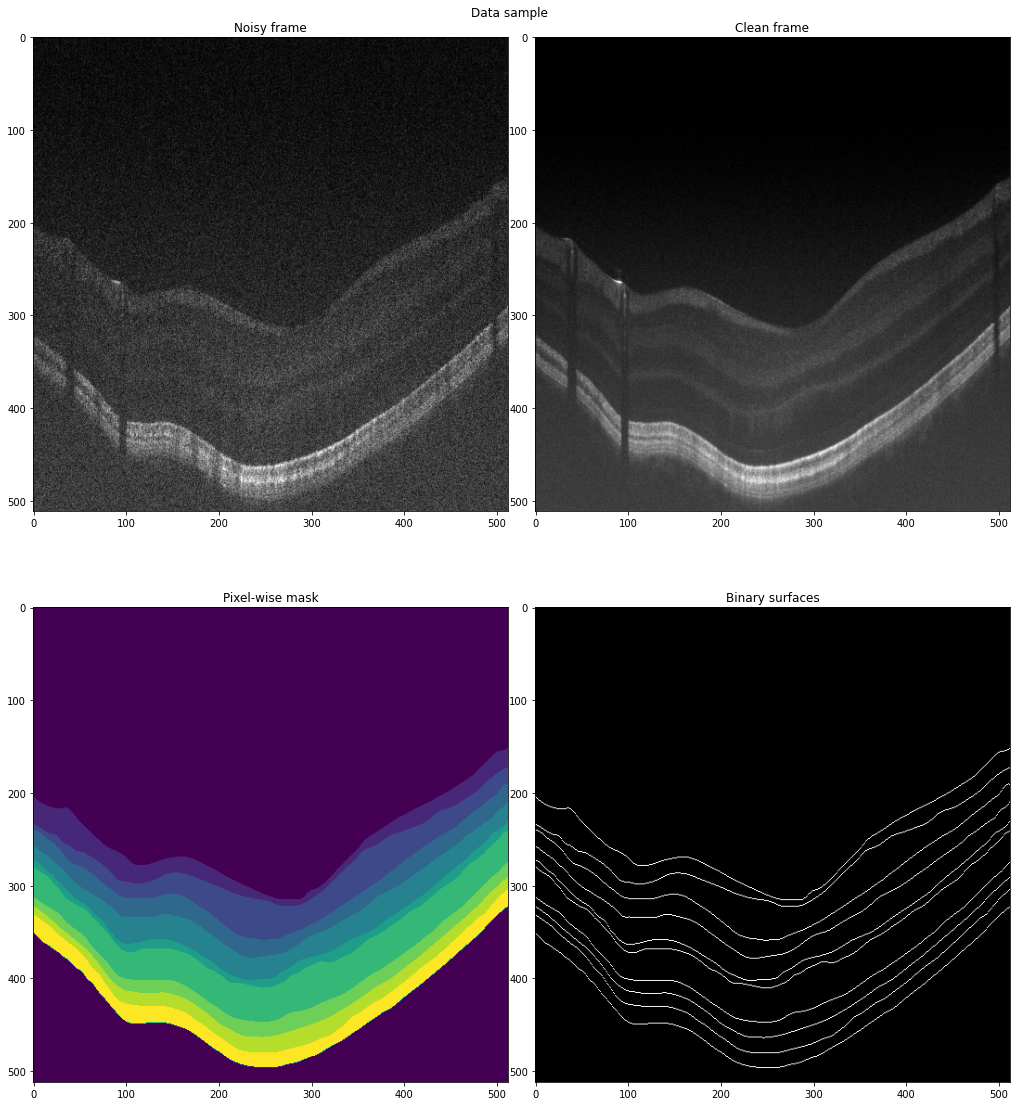

In [5]:
# Display data sample
sl = 21
plt.figure(figsize=(14,16))
plt.suptitle('Data sample')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplot(2,2,1)
plt.title('Noisy frame', fontsize=12)
plt.imshow(test_noisy_images[sl],cmap = 'gray')
plt.subplot(2,2,2)
plt.title('Clean frame', fontsize=12)
plt.imshow(test_images[sl],cmap = 'gray')
plt.subplot(2,2,3)
plt.title('Pixel-wise mask', fontsize=12)
plt.imshow(filled_test[sl,:,:])
plt.subplot(2,2,4)
plt.title('Binary surfaces', fontsize=12)
plt.imshow(label1_test[sl],cmap = 'gray')
plt.tight_layout(pad=0.2, w_pad=0, h_pad=0)
plt.show()

## Creating one-hot pixel-wise label

In [6]:
# One-hot encode the pixel-wise label with 10 layer classes
def onehotfrompixels(label):
    label_ = np.zeros([label.shape[0],label.shape[1],label.shape[2],10])
    for i in range(label.shape[0]):

        for layer in range(10):
            label_[i,:,:,layer] = label[i,...]==layer

    return label_

training_labels = onehotfrompixels(filled_train)
validating_labels = onehotfrompixels(filled_valid)
testing_labels = onehotfrompixels(filled_test)

# Data preparation

In [20]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1
number_of_annotated_training_images = 13

print('training data shape', train_images.shape,training_labels.shape)
print('validation data shape', validation_images.shape,validating_labels.shape)

# Use noisy or clean images to train
# resized_train_images = train_images
training_images = train_noisy_images

# resized_valid_images = validation_images
validating_images = validation_noisy_images

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(training_images, training_labels, random_seed=seed)

# Here we convert the number of annotated images to be used for training as percentage of available training data.
percentage_of_annotated_training_images = float((number_of_annotated_training_images/training_images.shape[0])*100.0)
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Augmented by horizontal flip
X, Y_train_masks = augment_data(X_frac, Y_frac)

X_val, Y_val_masks = validating_images, validating_labels

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = Y_train_masks

X_val = X_val[...,np.newaxis]
Y_val = Y_val_masks

# Repeat once for larger batch size and better random cropping
for i in range(1):
    X = np.concatenate([X,X])
    Y = np.concatenate([Y,Y])

print("percentage of annotated images is: {} %".format(percentage_of_annotated_training_images))
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

training data shape (51, 512, 512) (51, 512, 512, 10)
validation data shape (18, 512, 512) (18, 512, 512, 10)
Raw image size after augmentation (102, 512, 512)
Mask size after augmentation (102, 512, 512, 10)
percentage of annotated images is: 25.49019607843137 %
Shape of X:     (204, 512, 512, 1)
Shape of Y:     (204, 512, 512, 10)
Shape of X_val: (18, 512, 512, 1)
Shape of Y_val: (18, 512, 512, 10)


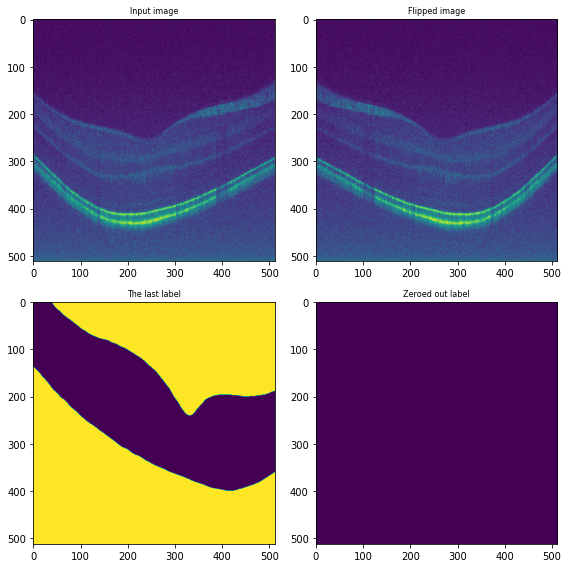

In [8]:
# Making sure the input data is correct
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title('Input image', fontsize=8)
plt.imshow(X[0,...,0])
plt.subplot(2,2,2)
plt.title('Flipped image', fontsize=8)
plt.imshow(X[51,...,0])
plt.subplot(2,2,3)
plt.title('The last label', fontsize=8)
plt.imshow(Y[number_of_annotated_training_images-1,...,0])
# The 14th label should be zeroed out 
plt.subplot(2,2,4)
plt.title('Zeroed out label', fontsize=8)
plt.imshow(Y[number_of_annotated_training_images,...,0])
plt.tight_layout()

# Denoiseg

In [18]:
train_batch_size = 12
train_steps_per_epoch = min(400, max(int(X.shape[0]/train_batch_size), 10))
relative_weights = [0.5, 1.0, 1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
n2v_patch_shape=(256, 256)
# 10 class classification and 1 denoised image

conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=11, num_class=10,relative_weights = relative_weights,
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200,unet_residual = False,
                      batch_norm=True, train_batch_size=train_batch_size, unet_n_first = 96,
                      unet_n_depth=5, denoiseg_alpha=0.5, train_tensorboard=False,n2v_perc_pix=1.5,
                      n2v_patch_shape=n2v_patch_shape, n2v_neighborhood_radius=5,train_loss= 'denoiseg',
                      network='ResidualUNet',n_conv_per_depth = 2, dropout=0,
                      if_superaug=0, visualize_traindata=0, n2vloss=2, train_learning_rate = 0.0004,optimizer = 'Adam',
                      train_reduce_lr= {'monitor': 'val_seg_loss', 'factor': 0.5, 'patience': 10})

vars(conf)

{'means': ['10678.813124413584'],
 'stds': ['8185.915921694076'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 11,
 'num_class': 10,
 'train_loss': 'denoiseg',
 'n_conv_per_depth': 2,
 'unet_n_depth': 5,
 'relative_weights': [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 17,
 'train_learning_rate': 0.0004,
 'train_batch_size': 12,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_seg_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (256, 256),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5,
 'n2vloss': 2,
 'ne

In [19]:
for i in range(1):
    model_name = 'final_experiments/DenoiSeg_OCT_25_%d' % i
    basedir = 'models'
    model = DenoiSeg(conf, model_name, basedir)
    history = model.train(X, Y, (X_val, Y_val))

983 blind-spots will be generated per training patch of size (256, 256).


NameError: ignored

# Visualization

Loading network weights from 'weights_best.h5'.


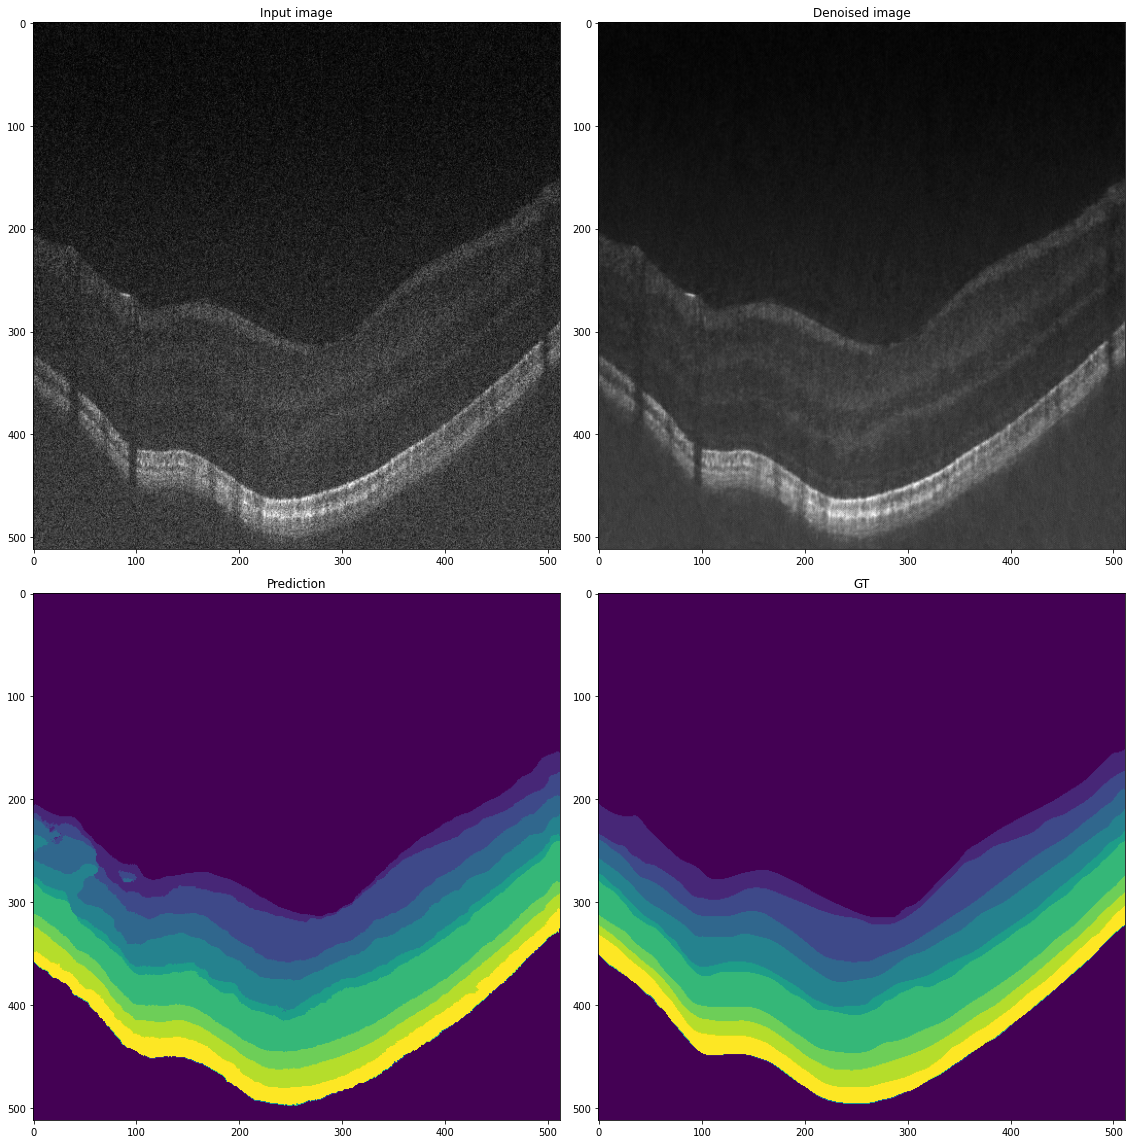

In [23]:
# Load saved model
model_name = 'pretrained_models/DenoiSeg_OCT_25_pretrained'
basedir = 'models'
model = DenoiSeg(None, model_name, basedir)
vars(model)

sl = 21
input_images = test_noisy_images[sl]
prediction = model.predict(input_images,'YX')

prediction_exp = np.exp(prediction[..., 1:])
prediction_softmax = prediction_exp / np.sum(prediction_exp, axis=2)[..., np.newaxis]
prediction_img = np.argmax(prediction_softmax,2)


plt.figure(figsize=(16,16))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplot(2,2,1)
plt.title('Input image',fontsize=12)
plt.imshow(input_images,cmap='gray')
plt.subplot(2,2,2)
plt.title('Denoised image',fontsize=12)
plt.imshow(prediction[:,:,0],cmap='gray')
plt.subplot(2,2,3)
plt.title('Prediction',fontsize=12)
plt.imshow(prediction_img)
plt.subplot(2,2,4)
plt.title('GT',fontsize=12)
plt.tight_layout()
plt.imshow(np.argmax(testing_labels[sl],2))